In [22]:
# install.packages('forestplot')
# install.packages('gdata')
# install.packages('chron')

In [23]:
library(forestplot)
library(gdata)
library(ggplot2)
library(scales)
library(chron)
library(dplyr)
library(data.table)
library(tidyr)
library(ggrepel)

In [24]:
genename="ITGA4"
# assign original colours to cell types
df_colours = data.frame(colours = c("#882E72","#B178A6","#D6C1DE","#1965B0","#5289C7","#7BAFDE","#4EB265",
                                    "#90C987","#CAE0AB","#F7EE55","#F6C141","#F1932D","#E8601C","#DC050C"),
                        celltype = c("CD4_NC","CD4_ET","CD4_SOX4","CD8_ET","CD8_NC","CD8_S100B","NK","NK_R",
                                     "Plasma","B_Mem","B_IN","Mono_C","Mono_NC","DC"))

In [25]:
dir = "/directflow/SCCGGroupShare/projects/anncuo/OneK1K/saige_eqtl/from_wei/Feb24/"
data = fread(paste0(dir,"all_ct_loci.list.withCate.qvalue"), header=T, data.table=F)
head(data,2)

,celltype,gene,R1,R2,R3,R4,R5,R6,pval_beta,pval_nominal,⋯,R3_Loci,R4_Loci,R5_Loci,R6_Loci,R1_topPval,R2_topPval,R3_topPval,R4_topPval,R5_topPval,R6_topPval
,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,B_IN,A1BG,0.00170947,0.3706712,0.7981946,1.0000000,1.0000000,1.0000000,0.0040709,6.147731e-06,⋯,19:57957633:T:A,19:57863937:T:C,19:58872853:G:C,19:58733610:G:T,1.13564e-05,0.00402990,0.00845249,0.00692103,0.0119666,0.0103745
2,B_IN,A1BG.AS1,0.86506417,0.7648255,0.7769261,0.8074401,0.8690257,0.8953325,0.1423371,4.116421e-04,⋯,19:58824721:C:T,19:57859145:G:T,19:57945146:T:A,19:58748944:G:A,5.88327e-03,0.00940976,0.02022780,0.06795570,0.3637510,0.0601790


In [26]:
data = data[which(data$gene == genename),]
head(data,2)

,celltype,gene,R1,R2,R3,R4,R5,R6,pval_beta,pval_nominal,⋯,R3_Loci,R4_Loci,R5_Loci,R6_Loci,R1_topPval,R2_topPval,R3_topPval,R4_topPval,R5_topPval,R6_topPval
,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
4814,B_IN,ITGA4,0.8744711,0.8022249,0.8993370,0.8635335,0.8724451,0.9139036,0.98189605,1.432176e-02,⋯,2:181448039:C:T,2:183075689:C:T,2:182993567:C:A,2:181646564:T:A,0.00145890,0.00382309,0.0145627,0.03786180,0.07822490,0.0135945
16767,B_Mem,ITGA4,0.8385505,0.6380550,0.7965836,0.9444883,0.8815404,0.9127550,0.01659574,2.331946e-05,⋯,2:181676117:G:T,2:182305254:T:C,2:182353604:T:C,2:182055696:T:C,0.00123599,0.00669367,0.0398372,0.00521906,0.00971185,0.0138071


In [27]:
databetase = fread(paste0(dir,"all_ct_loci.list.withCate.gene.celltype.tophit.beta.se.",genename), header=T, data.table=F)
data2 = merge(data, databetase, by.x=c("celltype","gene"), by.y=c("celltype","gene"))
head(data2,2)

,celltype,gene,R1,R2,R3,R4,R5,R6,pval_beta,pval_nominal,⋯,R2_topPval,R3_topPval,R4_topPval,R5_topPval,R6_topPval,tophit,freq,Beta,SE,pvalue
,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
1,B_IN,ITGA4,0.8744711,0.8022249,0.8993370,0.8635335,0.8724451,0.9139036,0.98189605,1.432176e-02,⋯,0.00382309,0.0145627,0.03786180,0.07822490,0.0135945,2:182323766,0.538187,0.00189111,0.0199757,0.924577
2,B_Mem,ITGA4,0.8385505,0.6380550,0.7965836,0.9444883,0.8815404,0.9127550,0.01659574,2.331946e-05,⋯,0.00669367,0.0398372,0.00521906,0.00971185,0.0138071,2:182323766,0.538187,-0.01554210,0.0247064,0.529302


In [28]:
celltypevec = data2$celltype
freqvec = round(data2$freq, digits=2)
betavec = round(data2$Beta, digits=2)
sevec = round(data2$SE, digits=2)
pvec = format(data2$pvalue, scientific = TRUE, digits=2)

In [29]:
#FDRvec = format(data2$R1_qvalue, scientific = TRUE, digits=2)
lowervec = betavec - 1.96*sevec
highervec = betavec + 1.96*sevec

In [30]:
cochrane_from_rmeta = data.frame(mean = c(NA,as.vector(betavec)), lower = c(NA, as.vector(lowervec)), upper = c(NA, as.vector(highervec)))  
tabletext <- cbind(
  c( "Cell type",celltypevec),
  #c("Freq",freqvec),
  c("Beta",betavec),
  c("SE",sevec),
  c("P-value", pvec))
#c("FDR", FDRvec))  

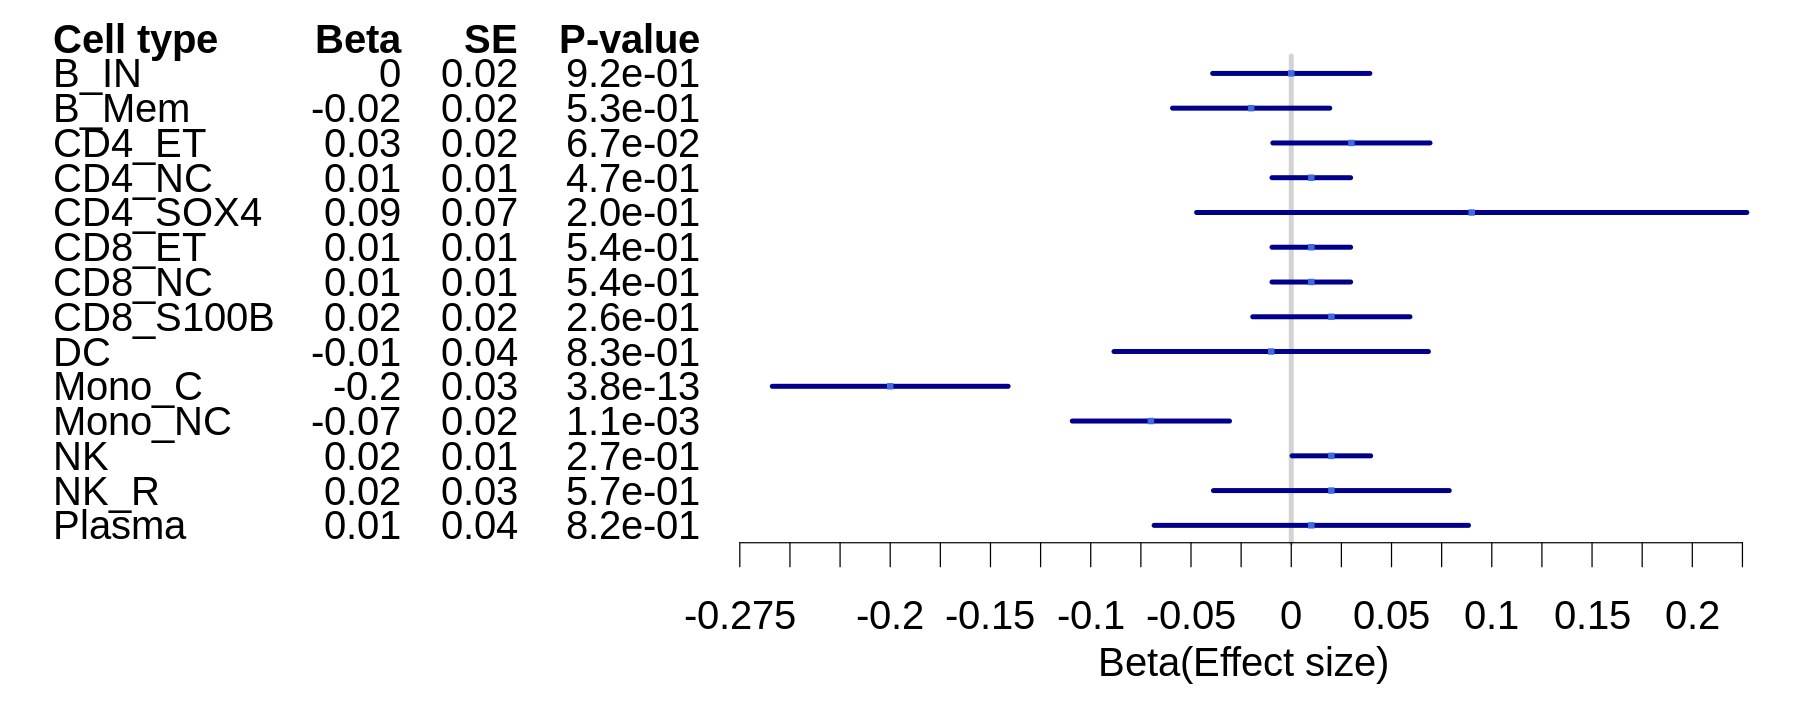

In [31]:
# pdf(paste0("gene_", genename,"_SAIGEQTL.pdf"), width=18)
options(repr.plot.width = 15, repr.plot.height = 6)
p = forestplot(tabletext, 
           #hrzl_lines = gpar(col = "#444444"),
           cochrane_from_rmeta,
           new_page = FALSE,
           align = c("l","r", "r","r"),
           is.summary = c(TRUE, rep(FALSE,nrow(tabletext)-2),FALSE),
           #xlog=xlogval,
           xlab="Beta(Effect size)",
           # clip=c(0.01,5),
           #clip=c(-2,2),
           col = fpColors(box = "royalblue",
                          line = "darkblue",
                          summary = "royalblue"), 
           boxsize=0.15, lwd.zero=4,lwd.ci=4,
           txt_gp = fpTxtGp(ticks=gpar(cex=2), summary = gpar(cex=2), label= gpar(cex=2), xlab= gpar(cex=2))
           
)
p
# dev.off()

In [32]:
fig_dir <- "/share/ScratchGeneral/anncuo/OneK1K/saige_eqtl/ms_figures/weis_figures/"
pdf(paste0(fig_dir,"forestplot.pdf"), width=15, height=6)
p
dev.off()

png 
  2